In [2]:
import pandas as pd
import pymysql
from datetime import datetime 
import time
import FinanceDataReader as fdr
import numpy as np
from dateutil.relativedelta  import relativedelta
import scipy.optimize as optm
import json 
import urllib.request
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from matplotlib.dates import MonthLocator, DateFormatter, WeekdayLocator

### sql 접속

In [ ]:
# 접속
stock_db = pymysql.connect(
    user='crawler',
    passwd='crawler123!',
    host='137.68.248.74', 
    port=3306,
    db='stockdata', 
    charset='utf8'
    )

#### [From DB] 1. 시총 500억이상 / 2. 같은 분야별 시총이 가장 큰 ETF 가져오기

In [ ]:
sql = "select ticker, ticker_name, net_asset from tb_etf_info"

cur = stock_db.cursor()
cur.execute(sql)
stock_db.commit()

result = cur.fetchall()

In [ ]:
etf_df = pd.DataFrame(result)
etf_df.columns = ['ticker', 'ticker_name', 'net_asset']

# 시가총액 500억 이상인 ETF 필터
etf_df_2 = etf_df[ etf_df['net_asset'] > 500 ]
etf_df_3 = etf_df_2.set_index('ticker_name')
select_etf = pd.concat([etf_df_2['ticker_name'], etf_df_2['net_asset']], axis = 1)

# 같은 분야별 ETF 시가총액이 가장 큰 ETF 필터
select_etf_2 =  select_etf.groupby([select_etf['ticker_name'].map(lambda x: x.split(' ')[1]),
                     select_etf['ticker_name']]).max().sort_values(by = 'net_asset', ascending = False)
select_etf_3 = select_etf_2.unstack()
select_etf_4 = pd.DataFrame(select_etf_3.idxmax(axis=1).values).applymap(lambda x : x[1])
select_etf_4.columns = ['ticker_name']
select_etf_5 = select_etf_4.set_index('ticker_name')

select_etf_6 = pd.merge(left = etf_df_3,right = select_etf_5, on = 'ticker_name', how = 'right' )

### [From DB] 고객 설문데이터 불러오기

In [ ]:
sql = """
select user_id, srno, surv_date, period
from tb_surv
group by user_id, srno
order by user_id, srno
"""
cur = stock_db.cursor()
cur.execute(sql)
stock_db.commit()

result = cur.fetchall()
tb_surv = pd.DataFrame(result)
tb_surv.columns = ['user_id', 'srno', 'surv_date', 'period']

In [ ]:
#db에서 가져온 고객과 설문 정보
new_user = len(tb_surv.index) - 6
user_id = tb_surv.user_id[new_user]
srno = tb_surv.srno[new_user]
surv_date = tb_surv.surv_date[new_user]
surv_period = tb_surv.period[new_user]

### [From DB] 종가데이터 가져오기 (2018-10-01 ~ 2020-08-14)

In [ ]:
start = '2018-10-01'
end = '2020-08-14'

ticker = '(' + str(select_etf_6['ticker'].tolist())[1:-1] + ')'

In [ ]:
sql = "SELECT ticker, k_date, close  FROM TB_ETF_PRICE WHERE TICKER IN " + ticker + ' AND '\
+ "K_DATE BETWEEN" + " DATE('" +  start + "')" + " AND " + "DATE('" + end + "')"
cur = stock_db.cursor()
cur.execute(sql)
stock_db.commit()

result = cur.fetchall()

In [ ]:
tb_etf_price = pd.DataFrame(result)
tb_etf_price.columns = ['ticker', 'k_date', 'close']

tb_etf_price_2 = tb_etf_price.set_index(['k_date','ticker']).unstack()
tb_etf_price_3 = tb_etf_price_2.xs('close',axis=1)
tb_etf_price_3.index.name = 'Date'

# 2018-10-01 이후에 상장된 ETF 제외
etf_close = tb_etf_price_3.dropna(axis=1)
etf_close_2 = etf_close.applymap(lambda x : int(x))

In [ ]:
# 영업일 아닌경우 전날로 변경
surv_date = datetime.strptime(datetime.strftime(surv_date, '%Y-%m-%d'), '%Y-%m-%d') 
for i in list(range(10)) :
    if ( surv_date in etf_close_2.index.tolist() ) == True :
        break
    if ( surv_date in etf_close_2.index.tolist() ) == False :
        surv_date = surv_date - relativedelta( days= 1 )

### USER_CLASS 가져오기

In [ ]:
sql = "select class from tb_user_class where user_id = "\
+ str(user_id) + " and " + "srno = " + str(srno)

cur = stock_db.cursor()
cur.execute(sql)
stock_db.commit()

result = cur.fetchall()
#User의 class
user_class = result[0][0]

#### 1. start_date = (설문날짜 - 투자기간) / 2. end_date = 설문날짜

In [ ]:
# start_date, end_date 설정
surv_period_int = int(surv_period[0])

if surv_period_int == 1:
    start_date = datetime.strftime(surv_date-relativedelta(years= surv_period_int ),'%Y-%m-%d')
else :
    start_date = datetime.strftime(surv_date-relativedelta(months= surv_period_int ),'%Y-%m-%d')
end_date =  datetime.strftime(surv_date, '%Y-%m-%d')

### [FROM DB] 채권금리 DB에서 가져오기

In [ ]:
sql = """
select avg(close)
from tb_stk_price
where ticker = 'KR1YT'
And k_date between '%s' and '%s'
""" % (start_date, end_date)

cur = stock_db.cursor()
cur.execute(sql)
stock_db.commit()

result = cur.fetchall()
risk_free = float(result[0][0])

# 투자기간별 risk free rate 구하기
if surv_period == '1Y' :
    risk_free = risk_free * 0.01
elif surv_period == '3M' :
    risk_free = (risk_free * 0.01) / 4
elif surv_period == '6M' :
    risk_free = (risk_free * 0.01) / 2

### [ FROM DB ] ETF 통계 집계 데이터를 가져와 종목 선정하기
    1. [ ETF의 투자성향 정확도 ] count(*)로 필터 넣어서 상위 ETF 10개 추출
    2. [ 위험대비 수익률 ]필터 걸러진 10개 종목 대상으로 상위 SR 순으로 ETF 5개 추출

In [ ]:
sql = '''
SELECT A.TICKER, A.SD, A.MEAN, A.SR
FROM tb_etf_stat A,
	(
		select TICKER, PERIOD, COUNT(*) AS CNT
		FROM tb_etf_stat A
		WHERE PERIOD = '%s'
		AND CLASS = '%s'
        AND SURV_DATE BETWEEN DATE_SUB(DATE(NOW()), INTERVAL 1 YEAR) AND '%s'
		GROUP BY TICKER, PERIOD
		ORDER BY CNT DESC 
		LIMIT 10
	) B
WHERE A.TICKER = B.TICKER 
AND A.PERIOD = B.PERIOD
AND A.SURV_DATE = '%s'
ORDER BY SR DESC
LIMIT 5
;
''' %  (surv_period, user_class, end_date, end_date)

cur = stock_db.cursor()
cur.execute(sql)

stock_db.commit()
result = cur.fetchall()

In [ ]:
# 선정된 ETF TICKER 리스트
selected_stock = pd.DataFrame(result)
selected_stock.columns = ['ticker', 'std', 'mean', 'SR']
selected_stock[['std', 'mean', 'SR']] = selected_stock[['std', 'mean', 'SR']].applymap(lambda x : float(x))
selected_stock['ticker'].tolist()

### [FROM DB] ETF PRICE 데이터 가져와서 ETF 보유 비율 정하기 (MVO)

In [ ]:
selected_ticker_list = selected_stock['ticker'].tolist()

In [ ]:
# sharp ratio 구하기
if surv_period == '1Y' :
    selected_stock['mean'] = selected_stock['mean'] * 252
    selected_stock['std'] = selected_stock['std'] * np.sqrt(252)
    sharp_ratio = selected_stock['SR'] * np.sqrt(252)
    
elif surv_period == '3M' :
    selected_stock['mean'] = selected_stock['mean'] * 63
    selected_stock['std'] = selected_stock['std'] * np.sqrt(63)
    sharp_ratio = selected_stock['SR'] * np.sqrt(63)
    
elif surv_period == '6M' :
    selected_stock['mean'] = selected_stock['mean'] * 126
    selected_stock['std'] = selected_stock['std'] * np.sqrt(126)
    sharp_ratio = selected_stock['SR'] * np.sqrt(126)

# 상관관계 지수 구하기
corr = etf_close_2[selected_ticker_list].shift(1).pct_change()[start_date : end_date]
corr = corr.corr()

In [ ]:
index_data_li = []
for i in list(range(5)) :
    tmp_dict = {}
    tmp_dict['mean'] = selected_stock['mean'][i]
    tmp_dict['std'] = selected_stock['std'][i]
    tmp_dict['SR'] = sharp_ratio[i]
    index_data_li.append(tmp_dict)
    
index_info = pd.DataFrame(np.array([ [x['mean'],x['std'],x['SR']] for x in index_data_li ]),
                          index=selected_ticker_list, columns=['mean','std','SR'])

def op_func(w, idx_info, corr_info, rf):
    excess_return = np.dot(w, idx_info['mean']) - rf
    std = np.dot(np.dot((idx_info['std'] * w).T, corr_info), idx_info['std'] * w)
    return - excess_return / std

#bnds = tuple(map(lambda x:tuple(x),[[ 0.05, 1 - 0.05*len(index_info)] for _ in range(len(index_info))]))
#bnds = ( (0.15, 0.3), (0.15, 0.3), (0.1, 0.2), (0.2, 0.4) )
bnds = tuple([(0.05, 0.5)] * len(index_info))
cons = [{'type':'eq', 'fun': lambda x: sum(x) - 1 }]
#cons = [{'type':'eq', 'fun': lambda x: sum(x) - 1 }, {'type':'eq', 'fun': lambda x: sum(np.array(x) > 0) - len(index_info)}]
#cons = [{'type':'eq', 'fun': lambda x: sum(np.array(x) > 0) - len(index_info)}]
sol = optm.minimize(op_func, x0=[ 1/len(index_info) ] * len(index_info), bounds=bnds, constraints=cons, args=(index_info,corr,risk_free))
#sol = optm.minimize(op_func, x0=[ 1/len(index_info) ] * len(index_info), constraints=cons, args=(index_info,corr,risk_free))
#optm.minimize(op_func, x0=[ 1/len(index_info) ] * len(index_info), args=(index_info,corr,risk_free))

In [383]:
# 종목별 비중
etf_weight = list(map(lambda x:round(x,2),sol.x))
etf_weight_df = pd.DataFrame([selected_ticker_list, etf_weight]).T
etf_weight_df.columns = ['ticker', 'weight']

etf_weight_df

,ticker,weight
0,272560,0.05
1,122260,0.05
2,214980,0.5
3,130730,0.35
4,114260,0.05


### [FROM DB] etf name 가져오기

In [384]:
sql = "select ticker, ticker_name from tb_etf_info where ticker in " + '(' + str(selected_ticker_list)[1:-1] + ')'

cur = stock_db.cursor()
cur.execute(sql)
stock_db.commit()

result = cur.fetchall()
etf_name = pd.DataFrame(result)[1].tolist()

# 선정된 ticker에 해당하는 etf 종목명
etf_name

['KODEX 국고채3년',
 'KOSEF 통안채1년',
 'KOSEF 단기자금',
 'KODEX 단기채권PLUS',
 'KBSTAR 단기국공채액티브']

### [FROM DB] user class 명칭 가져오기

In [385]:
sql = "select * from tb_class"

cur = stock_db.cursor()
cur.execute(sql)
stock_db.commit()

result = cur.fetchall()
user_class_name = pd.DataFrame(result).set_index(0)[1][user_class]
"고객성향 : " + user_class_name

'고객성향 : 안전'

### 종목 비중 시각화

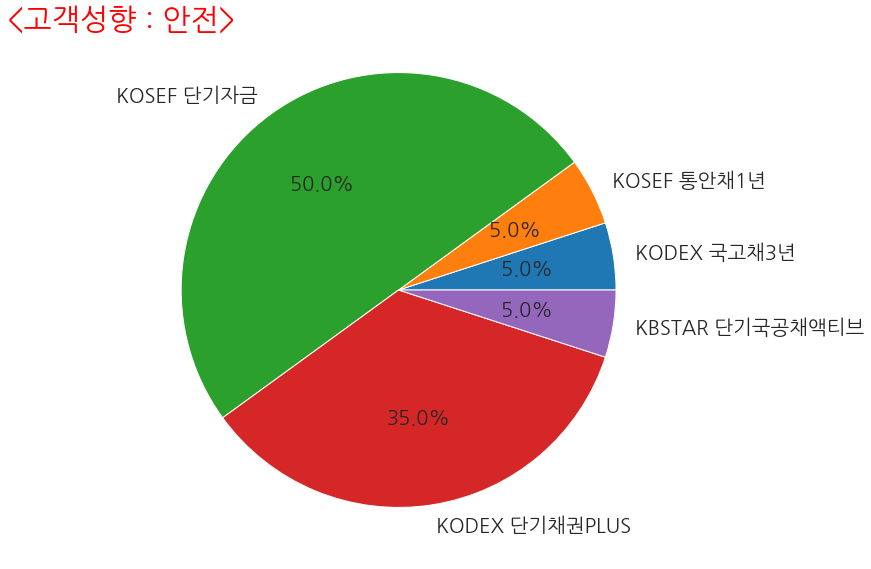

In [386]:
#테마설정
sns.set_style('dark')
#한글폰트 안깨지도록 하기
plt.rcParams['font.family'] = 'NanumGothic'
#폰트 크기 설정
plt.rcParams['font.size'] = 20
#시각화
plt.figure(figsize = (16,10))

font1 = {'color':  'red',
      'weight': 'normal',
      'size': 30}
plt.text(-1.8, 1.2, "<고객성향 : " + user_class_name + ">", fontdict = font1)

plt.pie(etf_weight, labels = etf_name, autopct='%0.1f%%')
plt.show()

### 백테스팅

In [387]:
etf_ret = etf_close_2.pct_change().dropna()

# 선정된 etf 각각의 일별수익률에 MVO를 통해 최적화된 weight 곱해줌
etf_1 = etf_ret[selected_ticker_list[0]].map(lambda x : x * etf_weight[0])
etf_2 = etf_ret[selected_ticker_list[1]].map(lambda x : x * etf_weight[1])
etf_3 = etf_ret[selected_ticker_list[2]].map(lambda x : x * etf_weight[2])
etf_4 = etf_ret[selected_ticker_list[3]].map(lambda x : x * etf_weight[3])
etf_5 = etf_ret[selected_ticker_list[4]].map(lambda x : x * etf_weight[4])

# 포트폴리오의 Daily 수익률 구하기
etf_final = pd.concat([etf_1,etf_2,etf_3,etf_4,etf_5], axis=1).sum(axis=1)

# 테스트 날짜 설정 (1개월, 3개월, 6개월, 1년)
test_start_1M = surv_date - relativedelta( days= 21 )
test_start_3M = surv_date - relativedelta( days= 63 )
test_start_6M = surv_date - relativedelta( days= 126 )
test_start_1Y = surv_date - relativedelta( days= 252 )

test_end = surv_date

# 1개월 / 3개월 / 6개월 / 1년으로 날짜 나누기
daily_1M_ret = etf_final.loc[test_start_1M : test_end]
daily_3M_ret = etf_final.loc[test_start_3M : test_end]
daily_6M_ret = etf_final.loc[test_start_6M : test_end]
daily_1Y_ret = etf_final.loc[test_start_1Y : test_end]

In [388]:
x_1M = pd.DataFrame(daily_1M_ret).index.map(lambda x : datetime.strftime(x, '%Y-%m-%d')).tolist()
x_3M = pd.DataFrame(daily_3M_ret).index.map(lambda x : datetime.strftime(x, '%Y-%m-%d')).tolist()
x_6M = pd.DataFrame(daily_6M_ret).index.map(lambda x : datetime.strftime(x, '%Y-%m-%d')).tolist()
x_1Y = pd.DataFrame(daily_1Y_ret).index.map(lambda x : datetime.strftime(x, '%Y-%m-%d')).tolist()

In [389]:
y_1M = daily_1M_ret.add(1).cumprod().tolist()
y_3M = daily_3M_ret.add(1).cumprod().tolist()
y_6M = daily_6M_ret.add(1).cumprod().tolist()
y_1Y = daily_1Y_ret.add(1).cumprod().tolist()

In [390]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


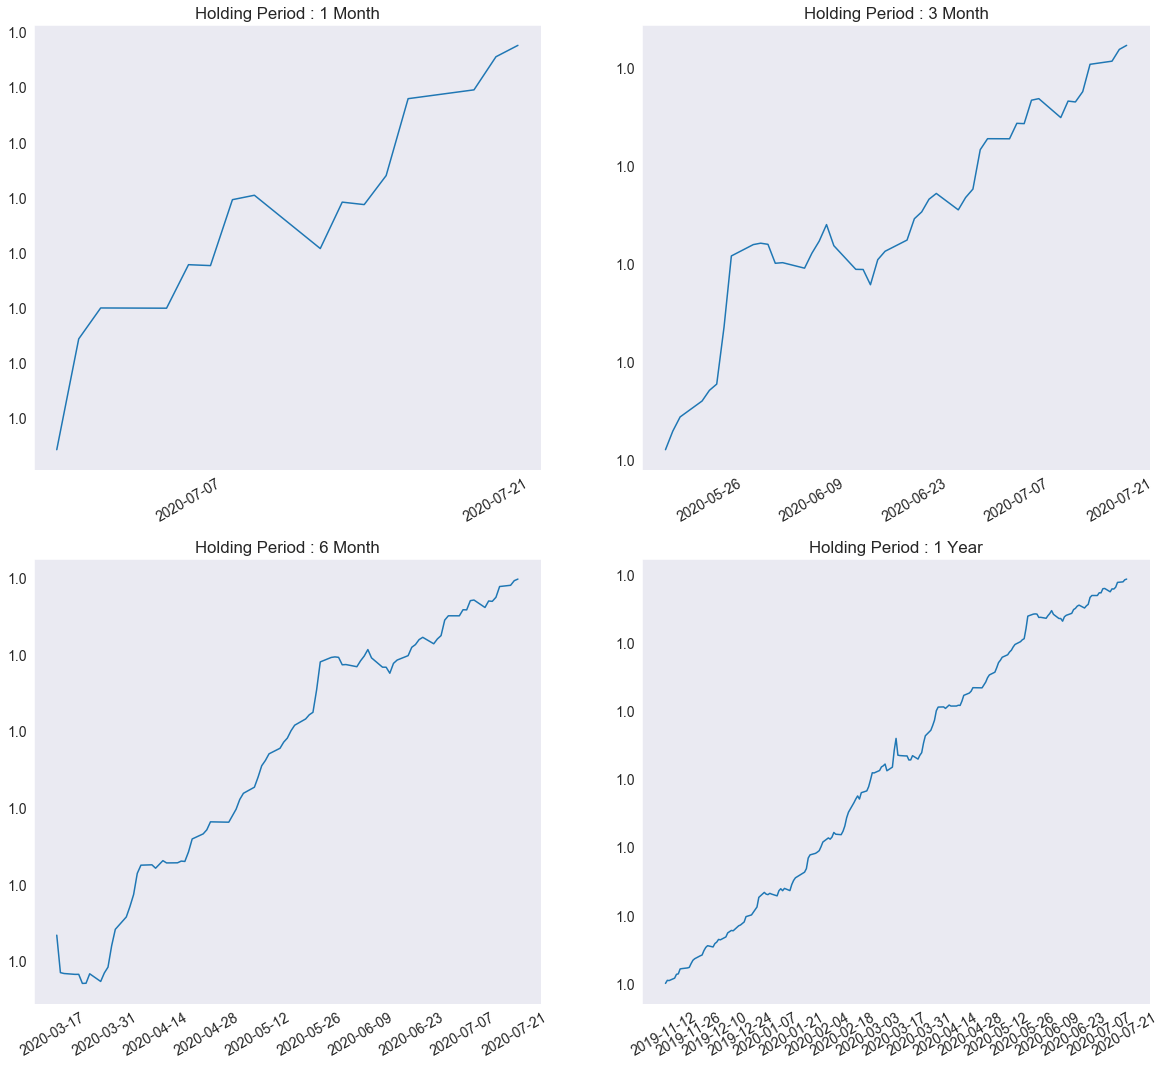

In [391]:
#한글폰트 안깨지도록 하기
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'
#폰트 크기 설정
sns.set_style('dark')
plt.rcParams['font.size'] = 14
weekFmt = DateFormatter('%Y-%m-%d')
weeks = WeekdayLocator(interval=2)
insert__list = [(0, 0, x_1M, y_1M, 'Holding Period : 1 Month'), (0, 1, x_3M, y_3M, 'Holding Period : 3 Month'),
                (1, 0, x_6M, y_6M, 'Holding Period : 6 Month'), (1, 1, x_1Y, y_1Y, 'Holding Period : 1 Year')]

fig, ax = plt.subplots(2, 2, figsize=(20, 18))

for i in insert__list :
    ax[i[0]][i[1]].set_title(i[4])
    ax[i[0]][i[1]].set_xticklabels(labels = i[2], rotation = 30)
    ax[i[0]][i[1]].set_yticklabels(labels = pd.Series(i[3]).map(lambda x : round(x, 2)))
    ax[i[0]][i[1]].plot_date(pd.to_datetime(i[2]), i[3],'-')     
    ax[i[0]][i[1]].xaxis.set_major_locator(weeks)   
    ax[i[0]][i[1]].xaxis.set_major_locator(weeks)
    ax[i[0]][i[1]].xaxis.set_major_formatter(weekFmt) 

plt.show()

### 벤치마크 대비 비교 차트

In [392]:
# 069500 - 코스피 / 148070 - kosef 국고채 10년
sql = """
select ticker, k_date, close
from tb_etf_price
where ticker in (069500, 148070)
"""
cur = stock_db.cursor()
cur.execute(sql)
stock_db.commit()

result = cur.fetchall()

In [393]:
bench_mark = pd.DataFrame(result)
bench_mark.columns = ['ticker', 'k_date', 'close']
bench_mark_2 = bench_mark.set_index(['k_date','ticker']).unstack()
bench_mark_3 = bench_mark_2.xs('close',axis=1)
bench_mark_3.index.name = 'Date'
bench_mark_4 = bench_mark_3.pct_change().applymap(lambda x : float(x))

In [394]:
#1개월 / 3개월 / 6개월 / 1년
bm_daily_1M = bench_mark_4.loc[test_start_1M : test_end]
bm_daily_3M = bench_mark_4.loc[test_start_3M : test_end]
bm_daily_6M = bench_mark_4.loc[test_start_6M : test_end]
bm_daily_1Y = bench_mark_4.loc[test_start_1Y : test_end]

#데이터 합치기
compar_1M = pd.concat([daily_1M_ret, bm_daily_1M['069500'], bm_daily_1M['148070']], axis = 1).add(1).cumprod()
compar_3M = pd.concat([daily_3M_ret, bm_daily_3M['069500'], bm_daily_3M['148070']], axis = 1).add(1).cumprod()
compar_6M = pd.concat([daily_6M_ret, bm_daily_6M['069500'], bm_daily_6M['148070']], axis = 1).add(1).cumprod()
compar_1Y = pd.concat([daily_1Y_ret, bm_daily_1Y['069500'], bm_daily_1Y['148070']], axis = 1).add(1).cumprod()

In [395]:
X_1M = pd.DataFrame(bm_daily_1M).index.map(lambda x : datetime.strftime(x, '%Y-%m-%d')).tolist()
X_3M = pd.DataFrame(bm_daily_3M).index.map(lambda x : datetime.strftime(x, '%Y-%m-%d')).tolist()
X_6M = pd.DataFrame(bm_daily_6M).index.map(lambda x : datetime.strftime(x, '%Y-%m-%d')).tolist()
X_1Y = pd.DataFrame(bm_daily_1Y).index.map(lambda x : datetime.strftime(x, '%Y-%m-%d')).tolist()

In [396]:
compar_1M.columns = ['Optimized_port', 'KODEX_200', 'KOSEF_Bond_10Y']
compar_3M.columns = ['Optimized_port', 'KODEX_200', 'KOSEF_Bond_10Y']
compar_6M.columns = ['Optimized_port', 'KODEX_200', 'KOSEF_Bond_10Y']
compar_1Y.columns = ['Optimized_port', 'KODEX_200', 'KOSEF_Bond_10Y']

In [397]:
compar_1M.columns

Index(['Optimized_port', 'KODEX_200', 'KOSEF_Bond_10Y'], dtype='object')

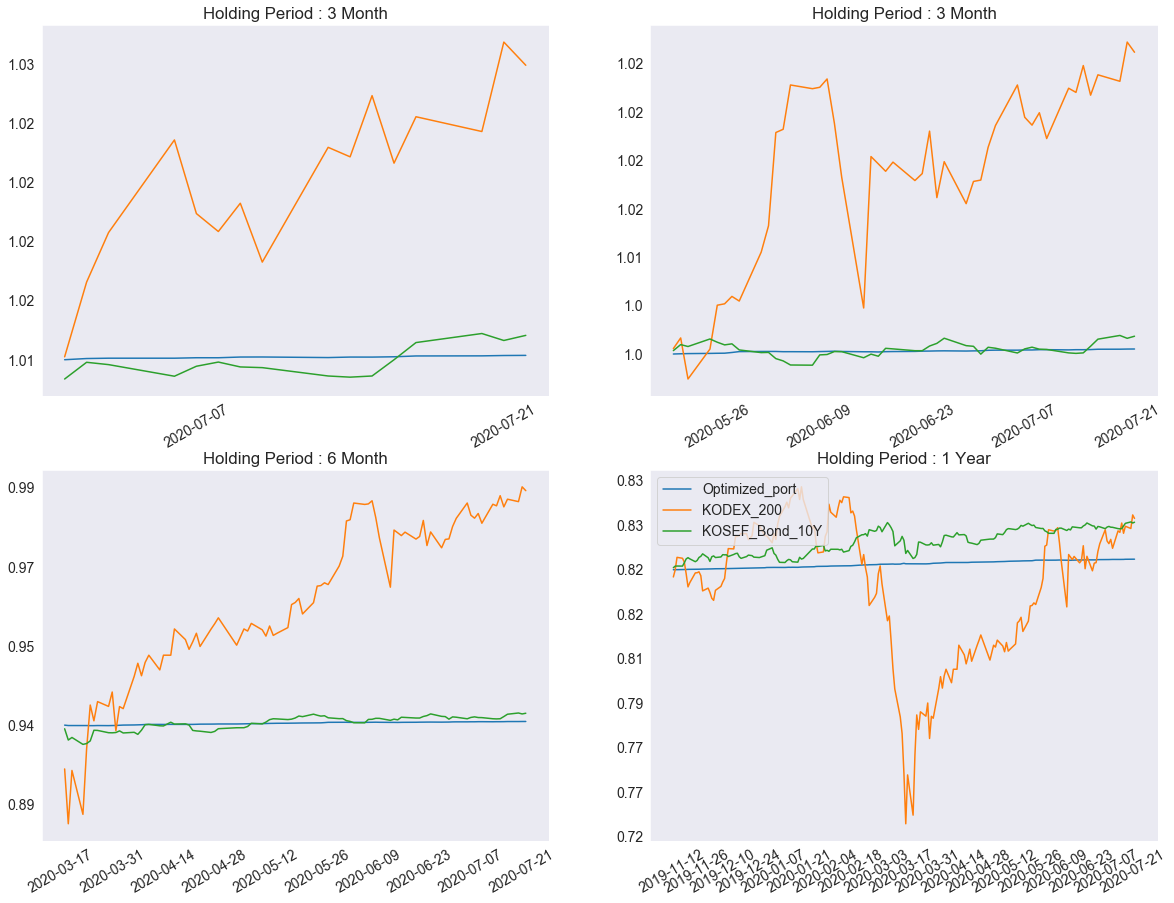

In [398]:
#한글폰트 안깨지도록 하기

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 14
#폰트 크기 설정
sns.set_style('dark')

weekFmt = DateFormatter('%Y-%m-%d')
weeks = WeekdayLocator(interval=2)
insert__list = [(0, 0, x_1M, compar_1M, 'Holding Period : 3 Month'),
                (0, 1, x_3M, compar_3M, 'Holding Period : 3 Month'),
                (1, 0, x_6M, compar_6M, 'Holding Period : 6 Month'),
                (1, 1, x_1Y, compar_1Y, 'Holding Period : 1 Year')]

fig, ax = plt.subplots(2, 2, figsize=(20, 15))

for i in insert__list :
    ax[i[0]][i[1]].set_title(i[4])
    ax[i[0]][i[1]].set_xticklabels(labels = i[2], rotation = 30)
    ax[i[0]][i[1]].set_yticklabels(labels = pd.Series(i[3]['KODEX_200']).sort_values().map(lambda x : round(x, 2)))
    ax[i[0]][i[1]].plot_date(pd.to_datetime(i[2]), i[3],'-')     
    ax[i[0]][i[1]].xaxis.set_major_locator(weeks)
    ax[i[0]][i[1]].xaxis.set_major_formatter(weekFmt) 
    
plt.legend(['Optimized_port', 'KODEX_200', 'KOSEF_Bond_10Y'], loc = 'upper left')
plt.show()